# Artifacts classification from EEG data

This code has been adapted from the following MNE Tools example: https://mne.tools/stable/auto_tutorials/sample-datasets/plot_sleep.html#sphx-glr-auto-tutorials-sample-datasets-plot-sleep-py

In [1]:
import os
import pandas as pd
import numpy as np
import bbtools as bbt
from datetime import timedelta
import matplotlib.pyplot as plt

import mne

from mne.time_frequency import psd_welch

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer

%matplotlib notebook

## Load the data

Here we download the data from two datasets and the end goal is to obtain epochs and its associated ground truth.

Previously, both datasets have been interactively labelled and these annotations have been saved in a different file:

 - <font color=blue>EEG.csv</font> containing the EEG. The raw data from the EEG helmet,

 - <font color=blue>interactive-annotations.csv</font> containing the annotations recorded manually.

Combining these two in a mne.io.Raw object then we can extract events based on the descriptions of the annotations to obtain the epochs.

Read the training and testing files and identify the channels used:

In [2]:
electrodes_used = ['Fp1', 'Fp2', 'F3', 'F4', 'C1', 'C3', 'C2', 'C4', 'CP1', 'CP3', 'CP2', 'CP4', 'Cz', 'O1', 'O2', 'Pz']
#electrodes_used = ["Fp1", "Fp2", "Af3", "Af4", "C3", "C1", "C2", "C4", "Cp3", "Cp1", "Cp2", "Cp4", "P7", "01", "02", "P8"]

eeg_train_file = "./data/4-artifacts-blink-jaw-eyesleft-eyesright-1-min-sequences-BBT-E16-AAA005-2019-11-29_18-22-04/EEG.csv"
annot_train_file = "./data/4-artifacts-blink-jaw-eyesleft-eyesright-1-min-sequences-BBT-E16-AAA005-2019-11-29_18-22-04/interactive-annotations.csv"
raw_train = bbt.read_csv(eeg_train_file, electrodes_used)

eeg_test_file = "./data/5-artifacts-blink-jaw-eyesleft-eyesright-30-sec-sequences-BBT-E16-AAA005-2019-11-29_18-32-13/EEG.csv"
annot_test_file = "./data/5-artifacts-blink-jaw-eyesleft-eyesright-30-sec-sequences-BBT-E16-AAA005-2019-11-29_18-32-13/interactive-annotations.csv"
raw_test = bbt.read_csv(eeg_test_file, electrodes_used)

Creating RawArray with float64 data, n_channels=16, n_times=65200
    Range : 0 ... 65199 =      0.000 ...   254.684 secs
Ready.
DigMontage is a superset of info. 78 in DigMontage will be ignored. The ignored channels are: {'TP7', 'FCz', 'T8', 'AF7', 'F5', 'PO10', 'P1', 'P8', 'A1', 'PO8', 'PO9', 'T9', 'TP8', 'FT7', 'F7', 'AF5', 'FT9', 'PO7', 'FC4', 'F9', 'CP5', 'PO4', 'T6', 'TP9', 'F1', 'POz', 'P9', 'F2', 'CPz', 'PO3', 'M1', 'FC1', 'AF9', 'O9', 'Fz', 'A2', 'T10', 'AF4', 'P5', 'Oz', 'PO2', 'P7', 'Fpz', 'M2', 'F10', 'CP6', 'AF8', 'PO1', 'T7', 'P4', 'P6', 'AF6', 'PO6', 'T3', 'F6', 'FT10', 'T5', 'FC5', 'FC6', 'FT8', 'P3', 'AF3', 'F8', 'FC2', 'P2', 'C6', 'PO5', 'AF1', 'AF2', 'TP10', 'O10', 'AFz', 'FC3', 'C5', 'Iz', 'T4', 'P10', 'AF10'}
Creating RawArray with float64 data, n_channels=16, n_times=32776
    Range : 0 ... 32775 =      0.000 ...   128.027 secs
Ready.
DigMontage is a superset of info. 78 in DigMontage will be ignored. The ignored channels are: {'TP7', 'FCz', 'T8', 'AF7', 'F5', 'P

Assign the annotations to each Raw object:

In [3]:
annot_train = mne.read_annotations(annot_train_file)
raw_train.set_annotations(annot_train, emit_warning=False) #remove events at time 0

annot_test = mne.read_annotations(annot_test_file)
raw_test.set_annotations(annot_test, emit_warning=False) #remove events at time 0

<RawArray  |  None, n_channels x n_times : 16 x 32776 (128.0 sec), ~4.0 MB, data loaded>

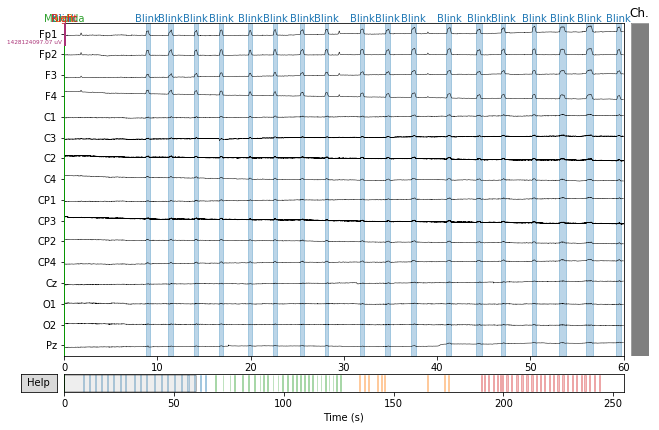

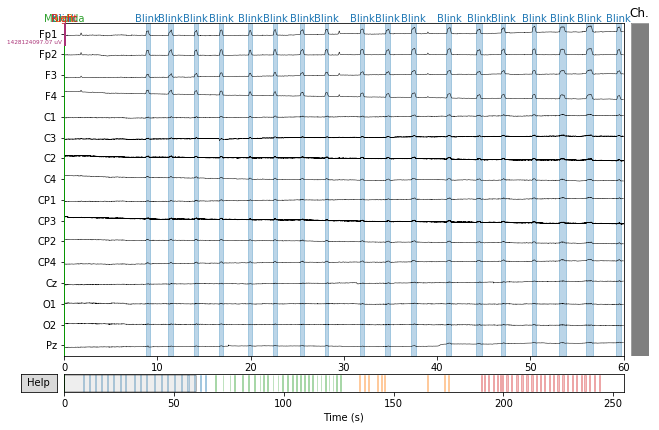

In [4]:
# plot some data
raw_train.plot(duration=60, scalings='auto')

## Extract events from annotations

The two datasets are annotated using 4 labels: Blink, Mordida (Jaw), Left (movement of eyes to the left), Right (movement of eyes to the right).

For the TRex game we will only be interested in two types of events: Blink, to jump and Mordida, to go down. To only work with these two types we will use the event_id parameter in mne.events_from_annotations() to select which events are we interested in and we associate an event identifier to each of them.

Used Annotations descriptions: ['Blink', 'Mordida']
Used Annotations descriptions: ['Blink', 'Mordida']


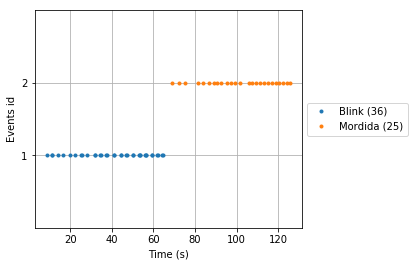

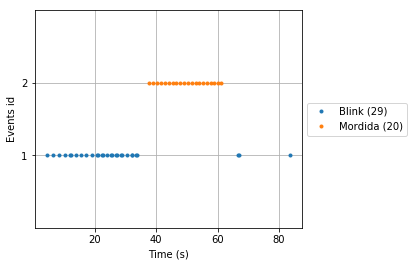

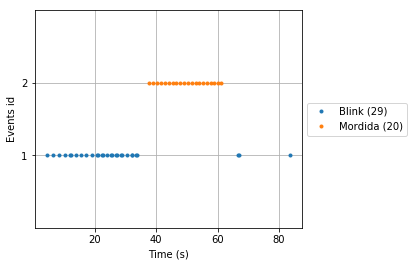

In [5]:
# define dictionnary of events
annotation_desc_2_event_id = {'Blink': 1,
                              'Mordida': 2}

# build the events array to be passed to epochs later
events_train, _ = mne.events_from_annotations(
    raw_train, event_id=annotation_desc_2_event_id, chunk_duration=0.23)


events_test, _ = mne.events_from_annotations(
    raw_test, event_id=annotation_desc_2_event_id, chunk_duration=0.23)

# plot training events
mne.viz.plot_events(events_train, event_id=annotation_desc_2_event_id,
                    sfreq=raw_train.info['sfreq'])

# keep the color-code for further plotting
stage_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# plot testing events
mne.viz.plot_events(events_test, event_id=annotation_desc_2_event_id,
                    sfreq=raw_train.info['sfreq'])

##  Create Epochs from the data based on the events found in the annotations

In [6]:
tmax = 0.23 - 1. / raw_train.info['sfreq']  # calculate tmax
#tmax=0.2 #default, averigua qué tmax debe ser

epochs_train = mne.Epochs(raw=raw_train, events=events_train,
                          event_id=annotation_desc_2_event_id, tmin=0., tmax=tmax, baseline=None)

epochs_test = mne.Epochs(raw=raw_test, events=events_test,
                          event_id=annotation_desc_2_event_id, tmin=0., tmax=tmax, baseline=None)

print(epochs_train)
print(epochs_test)

61 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
49 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
<Epochs  |   61 events (good & bad), 0 - 0.226562 sec, baseline off, ~48 kB, data not loaded,
 'Blink': 36
 'Mordida': 25>
<Epochs  |   49 events (good & bad), 0 - 0.226562 sec, baseline off, ~48 kB, data not loaded,
 'Blink': 29
 'Mordida': 20>


## Feature Engineering

Observing the power spectral density (PSD) plot of the :term:epochs grouped by artifact we can see that different artifacts have different signatures. 

The rest of this section we will create EEG features based on relative power in specific frequency bands to capture this difference between the artifacts in our data. 

Loading data for 36 events and 59 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Loading data for 25 events and 59 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Loading data for 29 events and 59 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Loading data for 20 events and 59 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows


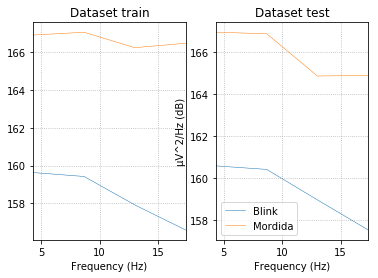

In [7]:
# visualize the two datasets by artifact
fig, (ax1, ax2) = plt.subplots(ncols=2)

# iterate over the datasets
stages = sorted(annotation_desc_2_event_id.keys())
for ax, title, epochs in zip([ax1, ax2],
                             ['Dataset train', 'Dataset test'],
                             [epochs_train, epochs_test]):

    for stage, color in zip(stages, stage_colors):
        epochs[stage].plot_psd(area_mode=None, color=color, ax=ax,
                               fmin=0.1, fmax=20., show=False,
                               average=True, spatial_colors=False)
    ax.set(title=title, xlabel='Frequency (Hz)')
ax2.set(ylabel='µV^2/Hz (dB)')
ax2.legend(ax2.lines[2::3], stages)
plt.show()

In [8]:
def eeg_power_band(epochs):
    """EEG relative power band feature extraction.

    This function takes an ``mne.Epochs`` object and creates EEG features based
    on relative power in specific frequency bands that are compatible with
    scikit-learn.

    Parameters
    ----------
    epochs : Epochs
        The data.

    Returns
    -------
    X : numpy array of shape [n_samples, 5]
        Transformed data.
    """
    # specific frequency bands
    FREQ_BANDS = {"delta": [0.5, 4.5],
                  "theta": [4.5, 8.5],
                  "alpha": [8.5, 11.5],
                  "sigma": [11.5, 15.5],
                  "beta": [15.5, 20]}

    psds, freqs = psd_welch(epochs, picks='eeg', fmin=0.5, fmax=30.)
    # Normalize the PSDs
    psds /= np.sum(psds, axis=-1, keepdims=True)

    X = []
    for fmin, fmax in FREQ_BANDS.values():
        psds_band = psds[:, :, (freqs >= fmin) & (freqs < fmax)].mean(axis=-1)
        X.append(psds_band.reshape(len(psds), -1))

    return np.concatenate(X, axis=1)

## Multiclass classification workflow using scikit-learn

In [10]:
#pipe = make_pipeline(FunctionTransformer(eeg_power_band, validate=False),
#                     RandomForestClassifier(n_estimators=100, random_state=42))

pipe = make_pipeline(RandomForestClassifier(n_estimators=100, random_state=42))


In [27]:
# Train
y_train = epochs_train.events[:, 2]

print(y_train.shape)

print(epochs_train)
test=epochs_train.get_data()
print(test.shape)

print(test[0,:,0])

(61,)
<Epochs  |   61 events (all good), 0 - 0.226562 sec, baseline off, ~48 kB, data not loaded,
 'Blink': 36
 'Mordida': 25>
Loading data for 61 events and 59 original time points ...
(61, 16, 59)
[  8353.54973834   4922.35657584   8132.18283004   3461.92876467
  -6325.10950408   4638.07050727   5257.08991544 -23487.51202817
  -7566.88380334   6793.84568879  -3007.74514536  -6872.76537038
   3456.19777947   4298.12939343    661.53334087   8682.40608037]


In [20]:
forest = RandomForestClassifier(n_estimators=100, random_state=42)
forest.fit (test, y_train)

ValueError: Found array with dim 3. Estimator expected <= 2.

In [14]:
pipe.fit(epochs_train, y_train)

ValueError: setting an array element with a sequence.

In [ ]:

# Test
y_pred = pipe.predict(epochs_test)

# Assess the results
y_test = epochs_test.events[:, 2]
acc = accuracy_score(y_test, y_pred)

print("Accuracy score: {}".format(acc))